In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_pathfile = '/kaggle/input/titanic/train.csv'
test_pathfile = '/kaggle/input/titanic/test.csv'
# example of model prediction
gender_submission_pathfile_example = '/kaggle/input/titanic/gender_submission.csv'

train_data = pd.read_csv(train_pathfile, index_col='PassengerId')
pred_X = pd.read_csv(test_pathfile, index_col='PassengerId')
pred_X_source = pred_X.copy()
example_predictions = pd.read_csv(gender_submission_pathfile_example)

Show example predictions for the Titanic Competition

In [3]:
example_predictions.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


Show DataFrame from the existed train data

In [4]:
df_shape = train_data.shape
print(f'DataFrame contains {df_shape[0]} rows and {df_shape[1]} columns.\n')
print(f'Contains the next columns: {train_data.columns}\n')
print(train_data.info(), '\n')

train_data.head()

DataFrame contains 891 rows and 11 columns.

Contains the next columns: Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None 



,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Ticket column does not have any valuable information for our data and I decided to delete in from dataframe.

In [5]:
# Ticket column doesn't provide any valuable information
data_X = train_data.drop(columns=['Survived', 'Ticket', 'Name'])
data_y = train_data['Survived']

pred_X = pred_X.drop(columns=['Ticket', 'Name'])

# Using pd.get_dummies to ['Sex', 'Embarked'] columns for changing object types to simple 0/1 to fit the model
columns_to_encode = ['Sex', 'Embarked']
columns_to_rename = {
    'Sex_female': 'Female',
    'Sex_male': 'Male',
    'Embarked_C': 'Cherbourg',
    'Embarked_Q': 'Queenstown',
    'Embarked_S': 'Southampton',
}

encoded_df = pd.get_dummies(data_X[columns_to_encode], columns=columns_to_encode, dtype=int)
encoded_df.rename(columns=columns_to_rename, inplace=True)

encoded_pred_df = pd.get_dummies(pred_X[columns_to_encode], columns=columns_to_encode, dtype=int)
encoded_pred_df.rename(columns=columns_to_rename, inplace=True)

# Fill missing values. I'll use 50 percentile to fill every NaN in Age column
data_X.Age = data_X.Age.fillna(data_X.Age.quantile())
pred_X.Age = pred_X.Age.fillna(pred_X.Age.quantile())
pred_X.Fare = pred_X.Fare.fillna(pred_X.Fare.mean())

data_X.drop(columns=columns_to_encode, inplace=True)
data_X = pd.concat([data_X, encoded_df], axis=1)
pred_X.drop(columns=columns_to_encode, inplace=True)
pred_X = pd.concat([pred_X, encoded_pred_df], axis=1)

data_X.head()

,Pclass,Age,SibSp,Parch,Fare,Cabin,Female,Male,Cherbourg,Queenstown,Southampton
PassengerId,,,,,,,,,,,
1,3,22.0,1,0,7.2500,NaN,0,1,0,0,1
2,1,38.0,1,0,71.2833,C85,1,0,1,0,0
3,3,26.0,0,0,7.9250,NaN,1,0,0,0,1
4,1,35.0,1,0,53.1000,C123,1,0,0,0,1
5,3,35.0,0,0,8.0500,NaN,0,1,0,0,1


The cabin numbers themselves are not of such great value to the model prediction that I need to parse each stateroom too carefully and assign it the appropriate coefficients, but instead I'm interested in floors, or more specifically - areas, A through G. I will split these values, remove the numerical cabin numbers, and create new values, where A is the largest value.

In [6]:
data_X.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [7]:
data_X.Cabin = data_X.Cabin.str.extract(r'([A-G])', expand=False)
data_X.Cabin.bfill()

pred_X.Cabin = pred_X.Cabin.str.extract(r'([A-G])', expand=False)
pred_X.Cabin.bfill()

encoded_cabin_column = pd.get_dummies(data_X.Cabin, dtype=int)
encoded_cabin_pred_column = pd.get_dummies(pred_X.Cabin, dtype=int)

data_X = data_X.drop(columns=['Cabin'])
data_X = pd.concat([data_X, encoded_cabin_column], axis=1)
pred_X = pred_X.drop(columns=['Cabin'])
pred_X = pd.concat([pred_X, encoded_cabin_pred_column], axis=1)

data_X.head()

,Pclass,Age,SibSp,Parch,Fare,Female,Male,Cherbourg,Queenstown,Southampton,A,B,C,D,E,F,G
PassengerId,,,,,,,,,,,,,,,,,
1,3,22.0,1,0,7.2500,0,1,0,0,1,0,0,0,0,0,0,0
2,1,38.0,1,0,71.2833,1,0,1,0,0,0,0,1,0,0,0,0
3,3,26.0,0,0,7.9250,1,0,0,0,1,0,0,0,0,0,0,0
4,1,35.0,1,0,53.1000,1,0,0,0,1,0,0,1,0,0,0,0
5,3,35.0,0,0,8.0500,0,1,0,0,1,0,0,0,0,0,0,0


In [8]:
pred_X.head()

,Pclass,Age,SibSp,Parch,Fare,Female,Male,Cherbourg,Queenstown,Southampton,A,B,C,D,E,F,G
PassengerId,,,,,,,,,,,,,,,,,
892,3,34.5,0,0,7.8292,0,1,0,1,0,0,0,0,0,0,0,0
893,3,47.0,1,0,7.0000,1,0,0,0,1,0,0,0,0,0,0,0
894,2,62.0,0,0,9.6875,0,1,0,1,0,0,0,0,0,0,0,0
895,3,27.0,0,0,8.6625,0,1,0,0,1,0,0,0,0,0,0,0
896,3,22.0,1,1,12.2875,1,0,0,0,1,0,0,0,0,0,0,0


The next step is convert Fare column using MinMaxScaler to interpret price before model fit

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(data_X, data_y, test_size=0.3, random_state=42)

scaler = MinMaxScaler()

X_train[['Fare', 'Age']] = scaler.fit_transform(X_train[['Fare', 'Age']])
X_valid[['Fare', 'Age']] = scaler.transform(X_valid[['Fare', 'Age']])
pred_X[['Fare', 'Age']] = scaler.transform(pred_X[['Fare', 'Age']])

X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Female,Male,Cherbourg,Queenstown,Southampton,A,B,C,D,E,F,G
PassengerId,,,,,,,,,,,,,,,,,
446,1,0.044986,0,2,0.159777,0,1,0,0,1,1,0,0,0,0,0,0
651,3,0.346569,0,0,0.015412,0,1,0,0,1,0,0,0,0,0,0,0
173,3,0.007288,1,1,0.021731,1,0,0,0,1,0,0,0,0,0,0,0
451,2,0.447097,1,2,0.054164,0,1,0,0,1,0,0,0,0,0,0,0
315,2,0.535059,1,1,0.051237,0,1,0,0,1,0,0,0,0,0,0,0


In [10]:
pred_X.head()

,Pclass,Age,SibSp,Parch,Fare,Female,Male,Cherbourg,Queenstown,Southampton,A,B,C,D,E,F,G
PassengerId,,,,,,,,,,,,,,,,,
892,3,0.428248,0,0,0.015282,0,1,0,1,0,0,0,0,0,0,0,0
893,3,0.585323,1,0,0.013663,1,0,0,0,1,0,0,0,0,0,0,0
894,2,0.773813,0,0,0.018909,0,1,0,1,0,0,0,0,0,0,0,0
895,3,0.334004,0,0,0.016908,0,1,0,0,1,0,0,0,0,0,0,0
896,3,0.271174,1,1,0.023984,1,0,0,0,1,0,0,0,0,0,0,0


Fit the model using above DataFrame, stay without changed the next columns: ['Pcalss', 'SibSp', 'Parch']
I will try to use RandomForestClassifier at this first lesson, then will try to use neural network

In [11]:
model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best Score: 0.8347354838709677


In [12]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid)

test_mae = mean_absolute_error(y_valid, y_pred)
print(f'MAE: {test_mae}')

MAE: 0.20149253731343283


In [13]:
y_result_prediction = best_model.predict(pred_X)
y_result_prediction = pd.Series(y_result_prediction, index=pred_X_source.index, name='Survived')

result = pred_X_source[['Name', 'Sex']].copy()
result['Survived'] = y_result_prediction.values
result['Ticket'] = pred_X[['A', 'B', 'C', 'D', 'E', 'F', 'G']].apply(lambda row: row.idxmax(), axis=1)

result.head()

,Name,Sex,Survived,Ticket
PassengerId,,,,
892,"Kelly, Mr. James",male,0,A
893,"Wilkes, Mrs. James (Ellen Needs)",female,0,A
894,"Myles, Mr. Thomas Francis",male,0,A
895,"Wirz, Mr. Albert",male,0,A
896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,0,A


In [14]:
survived = result[result['Survived'] == 1].Survived.sum()
total_passengers = result.shape[0]
died = total_passengers - survived

survived_man = result[(result['Sex'] == 'male') & (result['Survived'] == 1)].Name.count()
survived_woman = result[(result['Sex'] == 'female') & (result['Survived'] == 1)].Sex.count()
total_man = result[result['Sex'] == 'male'].Name.count()
total_woman = result[result['Sex'] == 'female'].Name.count()

print(f'Total passengers: {total_passengers}')
print(f'Survived people: {survived} / {round((survived / total_passengers) * 100, 2)}%\nDied people: {died} / {round((died / total_passengers) * 100, 2)}%')
print(f'Survived man/woman: {survived_man}({round((survived_man / total_man) * 100, 2)}%) / {survived_woman}({round((survived_woman / total_woman) * 100, 2)}%)')

Total passengers: 418
Survived people: 140 / 33.49%
Died people: 278 / 66.51%
Survived man/woman: 21(7.89%) / 119(78.29%)


In our case, in original dataset we have no enough information about cabin for a most of passengers, I include the next plot to show a dependency of passenger's cabin(and ticket price, soc. position, etc.) and surviving prediction. I was using .bfill() method to fill missing cabins!

Text(0, 0.5, 'People survived')

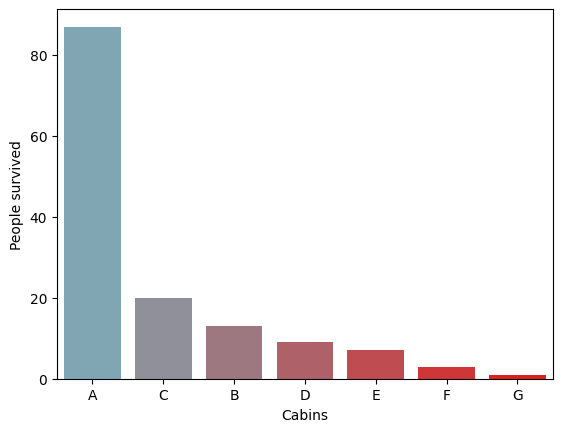

In [15]:
tickets_survival_sum = result.groupby('Ticket')['Survived'].sum().reset_index()
tickets_survival_sum = tickets_survival_sum.sort_values(by='Survived', ascending=False)

sns.barplot(data=tickets_survival_sum, x='Ticket', y='Survived', palette='blend:#7ab,red')
plt.xlabel('Cabins')
plt.ylabel('People survived')

Text(0.5, 1.0, 'Survival Counts by Gender')

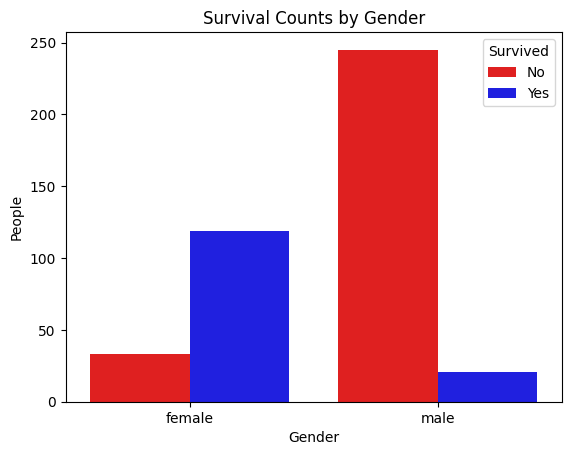

In [16]:
gender_data = result.groupby(['Sex', 'Survived']).size().reset_index(name='Count')

ax = sns.barplot(data=gender_data, x='Sex', y='Count', hue='Survived', palette=['red', 'blue'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['No', 'Yes'], title='Survived')

plt.xlabel('Gender')
plt.ylabel('People')
plt.title('Survival Counts by Gender')

In [17]:
result = result.reset_index()
result = result.drop(columns=['Name', 'Sex', 'Ticket'])

result.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
